<a href="https://colab.research.google.com/github/BeemoLin/Mongo_ML/blob/master/ResNet50_BMO_mongo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
from google.colab import drive
drive.mount('/content/drive')

!apt-get install unrar

!ls -al /content/drive/My\ Drive/C1-P1_Train_Dev.rar
!cp /content/drive/My\ Drive/C1-P1_Train_Dev.rar ./C1-P1_Train_Dev.rar
!rm -rf dataset
!mkdir dataset
!unrar x ./C1-P1_Train_Dev.rar ./dataset > /dev/null

!nvidia-smi

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Reading package lists... Done
Building dependency tree       
Reading state information... Done
unrar is already the newest version (1:5.5.8-1).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.
-rw------- 1 root root 662147036 Mar  8 05:26 '/content/drive/My Drive/C1-P1_Train_Dev.rar'
Sun Mar  8 16:26:54 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |  

In [12]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
import os, shutil

tf.logging.set_verbosity(tf.logging.ERROR)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
!nvidia-smi

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

# Helper libraries
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
from os import listdir
from os.path import join
import cv2
import pandas as pd
import random
import math
import sys

# Set the path of the input folder 
train_path = './dataset'

# step 1: 讀取資料集, 並且 resize 圖片
raw_data_path = './C1-P1_Train_Dev'
if os.path.exists(raw_data_path) and os.path.isdir(raw_data_path):
    os.rename(raw_data_path, train_path)
    
os.listdir(train_path)

train = pd.read_csv('./dataset/train.csv', header=None)
dev = pd.read_csv('./dataset/dev.csv', header=None)

print(train.head())
print(dev.head())

train_group = train.groupby(1)
dev_group = dev.groupby(1)

classes_names = train_group.groups.keys()

print(train_group.groups.keys())
print(dev_group.groups.keys())

    
#caculate images
print("統計資料集")
train_dir = './dataset/C1-P1_Train/'
val_dir = './dataset/C1-P1_Dev/'

for class_name in classes_names:
    train_folder_path = os.path.join(train_dir, class_name)
    print('train_folder_path=', train_folder_path)
    if not os.path.exists(train_folder_path):
        os.makedirs(train_folder_path)
        
    dev_folder_path = os.path.join(val_dir, class_name)
    print('dev_folder_path=', dev_folder_path)
    if not os.path.exists(dev_folder_path):
        os.makedirs(dev_folder_path)
        
train.apply(lambda x: shutil.move(os.path.join(train_dir, x[0]), os.path.join(train_dir, x[1], x[0])), axis=1)
dev.apply(lambda x: shutil.move(os.path.join(val_dir, x[0]), os.path.join(val_dir, x[1], x[0])), axis=1)

train_list = lambda name: os.path.join(train_dir, name)
val_list = lambda name: os.path.join(val_dir, name)

total_train = len(train)
total_val = len(dev)


print("-----Total:")
print("train:", total_train)
print("val:", total_val)

Sun Mar  8 14:46:09 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [13]:
batch_size = 128
epochs = 100
IMG_HEIGHT = 224
# IMG_HEIGHT = 56
IMG_WIDTH = IMG_HEIGHT

# from keras.applications.resnet50 import preprocess_input
from keras.applications.resnet_v2 import preprocess_input
# from keras.applications.mobilenet_v2 import preprocess_input
# from keras.applications.vgg16 import preprocess_input

print('Using real-time data augmentation.')
datagen = dict(
    # set input mean to 0 over the dataset
    featurewise_center=False,
    # set each sample mean to 0
    samplewise_center=False,
    # divide inputs by std of dataset
    featurewise_std_normalization=False,
    # divide each input by its std
    samplewise_std_normalization=False,
    # apply ZCA whitening
    zca_whitening=False,
    # epsilon for ZCA whitening
    zca_epsilon=1e-06,
    # randomly rotate images in the range (deg 0 to 180)
    rotation_range=5,
    # randomly shift images horizontally
    width_shift_range=0.2,
    # randomly shift images vertically
    height_shift_range=0.2,
    # set range for random shear
    shear_range=0.,
    # set range for random zoom
    zoom_range=0.,
    # set range for random channel shifts
    channel_shift_range=0.,
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    # value used for fill_mode = "constant"
    cval=0.,
    # randomly flip images
    horizontal_flip=True,
    # randomly flip images
    # vertical_flip=False,
    # set rescaling factor (applied before any other transformation)
    # rescale=None,
    # rescale=1./255,
    # set function that will be applied on each input
    preprocessing_function=preprocess_input,
    # image data format, either "channels_first" or "channels_last"
    data_format=None,
    # fraction of images reserved for validation (strictly between 0 and 1)
    validation_split=0.0)

train_image_generator = ImageDataGenerator(**datagen) # Generator for our training data
validation_image_generator = ImageDataGenerator(**datagen) # Generator for our validation data

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical')

val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=val_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='categorical')

train_data_gen.class_indices
val_data_gen.class_indices

Using real-time data augmentation.
Found 5600 images belonging to 3 classes.
Found 800 images belonging to 3 classes.


{'A': 0, 'B': 1, 'C': 2}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


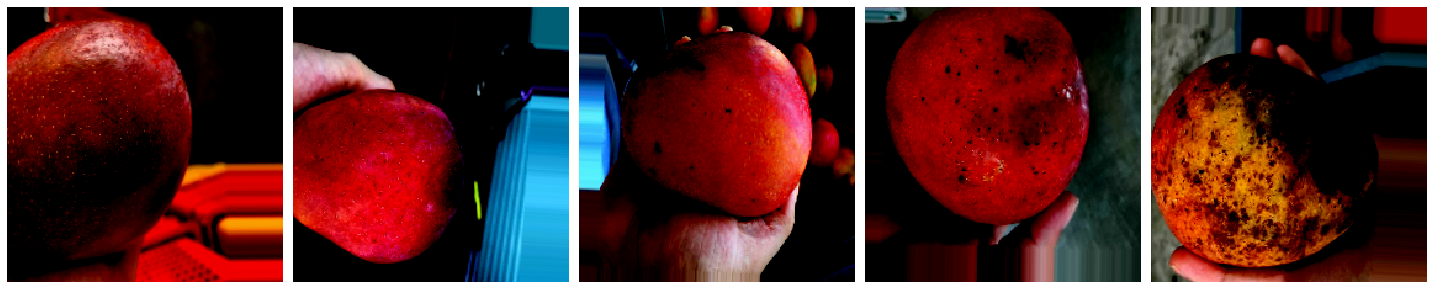

In [14]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])

In [15]:
from keras.models import load_model
from sklearn.datasets import load_files   
from keras.utils import np_utils
from glob import glob
from keras import applications
from keras.preprocessing.image import ImageDataGenerator 
from keras import optimizers
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import BatchNormalization, Concatenate, GlobalMaxPooling2D
from keras.callbacks import ReduceLROnPlateau, LambdaCallback, ModelCheckpoint, LearningRateScheduler

# 訓練用的超參數
batch_size = 32
epochs = 30
data_augmentation = True
num_classes = len(classes_names)
input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)

def create_resnet_50_model(num_classes=5, input_shape=(224, 224, 3)):

    model = applications.resnet_v2.ResNet50V2(include_top=False, pooling='avg', weights='imagenet', input_shape=input_shape)
    
    # model.summary()
    # model.trainable = False

    return model


# 架構主要 model
model_name = 'resnet50'

main_model = Sequential()

if model_name == 'resnet50':
  base_model = create_resnet_50_model(num_classes, input_shape)
  main_model.add(base_model)

  # 想辦法讓訓練不要這麼飄
  # main_model.add(BatchNormalization())
  # main_model.add(Dense(2048, activation='relu'))
  # main_model.add(BatchNormalization())
  # main_model.add(Dense(1024, activation='relu'))
  # main_model.add(BatchNormalization())
  main_model.add(Dense(num_classes, activation='softmax'))

# 因為是遷移學習，本來就有訓練了，縮小 learning rate，才不會讓訓練好的成果跑掉
# opt = optimizers.SGD(lr=1e-4, momentum=0.9)
opt = optimizers.Adam(lr=1e-4)
# opt=optimizers.RMSprop(lr=1e-5)

main_model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# 檢查是否凍結 ALL
print("--檢查 ALL 是否凍結-----------------")
for layer in main_model.layers:
    print(layer.name, ' is trainable? ', layer.trainable)

main_model.summary()

model = main_model

94674944/94668760 [==============================] - 7s 0us/step
--檢查 ALL 是否凍結-----------------
resnet50v2  is trainable?  True
dense_1  is trainable?  True
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 6147      
Total params: 23,570,947
Trainable params: 23,525,507
Non-trainable params: 45,440
_________________________________________________________________


In [17]:
# 訓練模型囉！
batch_size=128

# checkpoint 儲存最好的一個

# shutil.rmtree('best_loss', ignore_errors=True)
if not os.path.exists('best_loss'):
  os.makedirs('best_loss')

weight_path="./best_loss/epoch_{epoch:02d}_val_acc_{val_acc:.4f}_val_loss_{val_loss:.4f}.h5"
best_weight_path = "./best_weight.h5"

ck_epoch_weight = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                                          save_weights_only=True,
                                          save_best_only=True,
                                          mode='min')

ck_best_weight = ModelCheckpoint(best_weight_path, monitor='val_loss', verbose=1,
                                        save_weights_only=True,
                                        save_best_only=True,
                                        mode='min')

# 使用自動降低學習率 (當 validation loss 連續 5 次沒有下降時，自動降低學習率)
lr_reducer = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.8,
    patience=5,
    verbose=1,
    mode='auto',
    min_delta=0.0001,
    cooldown=5,
    min_lr=1e-14)

# early = EarlyStopping(monitor="val_loss", 
#                       mode="min", 
#                       patience=10) # probably needs to be more patient, but kaggle time is limited

# 學習率動態調整。當跑到第幾個 epcoh 時，根據設定修改學習率。這邊的數值都是參考原 paper
def lr_schedule(epoch):
    lr = 1e-4
    if epoch > 500:
        lr = 1e-7
    elif epoch > 200:
        lr = 1e-6
    elif epoch > 100:
        lr = 1e-5
    print('Learning rate: ', lr)
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

# 設定 callbacks
callbacks = [ck_epoch_weight, ck_best_weight, lr_reducer]

epochs = 5

history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size,
    callbacks=callbacks,
    workers=2
)

# 評估模型
# scores = model.evaluate(x_test, y_test, verbose=1)
# print('Test loss:', scores[0])
# print('Test accuracy:', scores[1])

Epoch 1/5
43/43 [==============================] - 147s 3s/step - loss: 0.3611 - acc: 0.8558 - val_loss: 0.6074 - val_acc: 0.7656

Epoch 00001: val_loss improved from inf to 0.60739, saving model to ./best_loss/epoch_01_val_acc_0.7656_val_loss_0.6074.h5

Epoch 00001: val_loss improved from inf to 0.60739, saving model to ./best_weight.h5
Epoch 2/5
43/43 [==============================] - 148s 3s/step - loss: 0.3114 - acc: 0.8805 - val_loss: 0.6968 - val_acc: 0.7440

Epoch 00002: val_loss did not improve from 0.60739

Epoch 00002: val_loss did not improve from 0.60739
Epoch 3/5
43/43 [==============================] - 142s 3s/step - loss: 0.2705 - acc: 0.8932 - val_loss: 0.7025 - val_acc: 0.7500

Epoch 00003: val_loss did not improve from 0.60739

Epoch 00003: val_loss did not improve from 0.60739
Epoch 4/5
43/43 [==============================] - 148s 3s/step - loss: 0.2224 - acc: 0.9130 - val_loss: 0.8925 - val_acc: 0.6920

Epoch 00004: val_loss did not improve from 0.60739

Epoch 000

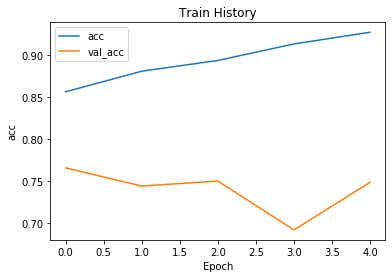

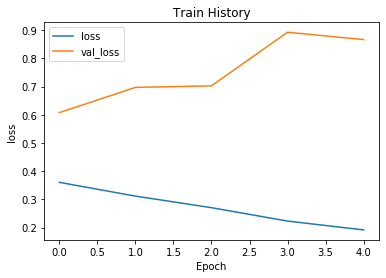

In [18]:
import matplotlib.pyplot as plt
def show_train_history(train,val):
    plt.plot(history.history[train])
    plt.plot(history.history[val])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend([train, val], loc='upper left')
    plt.show()
    
show_train_history('acc','val_acc')

show_train_history('loss','val_loss')

In [71]:
from google.colab import drive
drive.mount('/content/drive')

!apt-get install unrar

!ls -al /content/drive/My\ Drive/AIMango_sample.rar
!cp /content/drive/My\ Drive/AIMango_sample.rar ./AIMango_sample.rar
!rm -rf testset
!mkdir testset
!unrar e ./AIMango_sample.rar ./testset > /dev/null

#Set the path of the input folder 
pred_path = "./testset"

# read testset label
test = pd.read_csv('./testset/label.csv', header=None, encoding='big5')
print(test.head())

test[1] = test.apply(lambda x: x[1].replace('等級', ''), axis=1)
print(test.head())

test_group = test.groupby(1)

classes_names = test_group.groups.keys()

# split class
for class_name in classes_names:
    pred_folder_path = os.path.join(pred_path, class_name)
    print('pred_folder_path=', pred_folder_path)
    if not os.path.exists(pred_folder_path):
        os.makedirs(pred_folder_path)


test.apply(lambda x: shutil.move(os.path.join(pred_path, x[0]), os.path.join(pred_path, x[1], x[0])), axis=1)

#Test DataSet Generator with Augmentation
print("\nTest Data Set = ", pred_path)
pred_generator = ImageDataGenerator(**datagen) # Generator for our validation data

pred_flow = pred_generator.flow_from_directory(
    batch_size=128,
    directory=pred_path,
    shuffle=False,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    classes=classes_names,
    class_mode=None)

print("pred_flow.samples:", pred_flow.samples)
print("pred_flow.batch_size:", pred_flow.batch_size)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Reading package lists... Done
Building dependency tree       
Reading state information... Done
unrar is already the newest version (1:5.5.8-1).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.
-rw------- 1 root root 10773696 Mar  8 15:18 '/content/drive/My Drive/AIMango_sample.rar'
                       0    1
0    D-Plant2_0610_3.jpg  等級B
1   D-Plant2_0610_30.jpg  等級C
2  D-Plant2_0610_300.jpg  等級B
3  D-Plant2_0610_301.jpg  等級B
4  D-Plant2_0610_302.jpg  等級B
                       0  1
0    D-Plant2_0610_3.jpg  B
1   D-Plant2_0610_30.jpg  C
2  D-Plant2_0610_300.jpg  B
3  D-Plant2_0610_301.jpg  B
4  D-Plant2_0610_302.jpg  B
pred_folder_path= ./testset/A
pred_folder_path= ./testset/B
pred_folder_path= ./testset/C

Test Data Set =  ./testset
Found 94 images belonging to 3 classes.
pred_flow.samples: 94
pred_flow.batch_size: 128


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


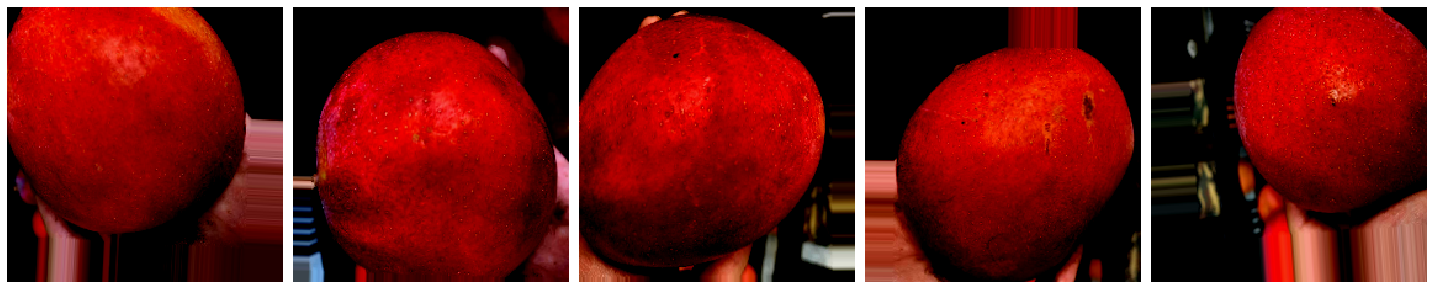

In [72]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

sample_training_images = next(pred_flow)
plotImages(sample_training_images[:5])

In [73]:
# from keras.models import load_model, load_weights
# w_path = './best_loss/epoch_48_val_acc_0.9394_val_loss_0.1512.h5'
# model.load_weights(w_path)
model.load_weights(best_weight_path)

# 預測結果
predictions = model.predict_generator(pred_flow, verbose=1)
predictions = np.argmax(predictions, axis=-1) #multiple categories
print(predictions)

1/1 [==============================] - 2s 2s/step
[0 0 0 0 0 2 0 0 0 2 0 0 0 0 0 0 2 2 1 1 2 2 2 2 2 1 1 2 1 2 1 2 2 1 2 2 2
 1 2 1 1 2 2 2 2 1 2 1 2 2 2 2 2 0 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [75]:
# 輸出 CSV
import time
timestr = time.strftime("%Y%m%d_%H%M%S")
output_path = './best_{}.csv'.format(timestr)

get_file_name = lambda x: os.path.splitext(os.path.basename(x))[0]

pd_output_result = pd.DataFrame({'Image': map(get_file_name, pred_flow.filenames), 'Grade': predictions})

def mongo_Grade(df):
    return list(classes_names)[df['Grade']]
 
pd_output_result['Grade'] = pd_output_result.apply(lambda x: mongo_Grade(x), axis=1)
pd_output_result.to_csv(output_path, encoding='utf-8', index=False)
print(pd_output_result.head())

# 儲存最好的結果 load model and weights
model.save('best_model.h5')

              Image Grade
0  G-Plant2_0616_83     A
1  G-Plant2_0616_84     A
2  G-Plant2_0616_85     A
3  G-Plant2_0616_86     A
4  G-Plant2_0616_87     A
